In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


$\mathcal{L} = \exp(-\lambda) \frac{1}{n!} \lambda ^n$ \
for easier minimalisation: \
$-2 \log (\mathcal{L})= - 2 n \log (\lambda) + 2 \lambda $

In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20_e import MapDatasetNuisanceE
from  my_fit_20 import Fit
import my_dataset_core_20_e , my_fit_20_e
from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : ESvCKe99 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

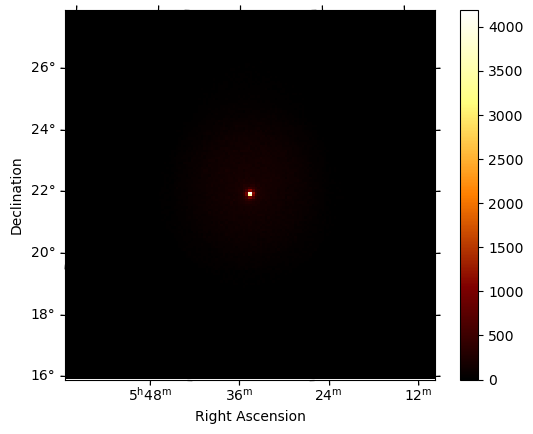

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [4]:
factor_neg = -0.1
factor_pos = +0.1
sigma = 0.1

In [5]:
sys_d_cor = sys_dataset(dataset_asimov, 0, False)
dataset_cor_N = sys_d_cor.create_dataset_N(sigma)

sys_d_neg = sys_dataset(dataset_asimov, factor_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N(sigma)

sys_d_pos = sys_dataset(dataset_asimov, factor_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N(sigma)



In [6]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor_N])
print("neg")
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg_N])
print("pos")
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos_N])

corr
neg
pos
CPU times: user 2min 8s, sys: 11.9 s, total: 2min 20s
Wall time: 2min 21s


In [7]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
    

best fit amplitude
====
Input
1e-12 pm 0.0
====
9.54178871443341e-13 pm 8.934687894685469e-14
1.0000000524597264e-12 pm 9.289878424493858e-14
1.0547815635705456e-12 pm 9.912966365017649e-14

best fit Index
====
Input
2.3 pm 0.0
====
2.3004302733511737 pm 0.06153756557426262
2.300000150477316 pm 0.06149548264978304
2.2999009641672514 pm 0.061526618780557485

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9533780677706178 pm 0.022455763667079808
1.0000000033216208 pm 0.02356184370546478
1.054232467163105 pm 0.02482891175013473


In [ ]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


In [ ]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='orange')

dataset_cor_N.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='orange')


                               
dataset_pos_N.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
fig.savefig("plots/2_spectrum.pdf")

## Multiple Poission Draws

In [8]:
N = 5
datasets_cor_N = []
datasets_neg_N = []
datasets_pos_N = []

sys_d_cor_rnd = sys_dataset(dataset_asimov, 0, True)
sys_d_neg_rnd = sys_dataset(dataset_asimov, factor_neg, True)
sys_d_pos_rnd = sys_dataset(dataset_asimov, factor_pos, True)


for n in range(N):
    datasets_cor_N.append(sys_d_cor_rnd.create_dataset_N(sigma))
    datasets_neg_N.append(sys_d_neg_rnd.create_dataset_N(sigma))
    datasets_pos_N.append(sys_d_pos_rnd.create_dataset_N(sigma))


In [10]:
%%time
fitting_poission_draws = False
if fitting_poission_draws:
    print("Corr")
    for i, d in enumerate(datasets_cor_N):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
    print("Neg")
    for i, d in enumerate( datasets_neg_N):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
    print("Pos")
    for i, d in enumerate (datasets_pos_N):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
        
        
    amplitudes_all_N = []
    indices_all_N = []
    norms_all_N = []

    datasets_p = [datasets_neg_N, datasets_cor_N, datasets_pos_N]
    for d_case in datasets_p:
        print("best fit amplitude")
        amplitudes_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['amplitude'].value 
            error = m.parameters['amplitude'].error
            amplitudes_p.append((value, error))
            print(f'{value} pm {error}')
        print()
        print("best fit Index")
        indices_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['index'].value 
            error = m.parameters['index'].error
            indices_p.append((value, error))
            print(f'{value} pm {error}')
        print()

        print("Best Fit bkg Norm")
        norms_p = []
        print('====')
        for d in d_case:
            value = d.background_model.parameters['norm'].value 
            error = d.background_model.parameters['norm'].error
            print(f'{value} pm {error}')
            norms_p.append((value, error))

        amplitudes_all_N.append(amplitudes_p)
        indices_all_N.append(indices_p)
        norms_all_N.append(norms_p)   



    with open('data/norms_all_N.yaml', 'w') as file:
        documents = yaml.dump(norms_all_N, file)
    with open('data/amplitudes_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitudes_all_N, file)
    with open('data/indices_all_N.yaml', 'w') as file:
        documents = yaml.dump(indices_all_N, file)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [11]:
if fitting_poission_draws ==False:
    with open('data/norms_all_N.yaml') as file:
        norms_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/amplitudes_all_N.yaml') as file:
        amplitudes_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/indices_all_N.yaml') as file:
        indices_all_N = yaml.load( file, Loader=yaml.FullLoader)

## Comparison

In [12]:
with open('data/norms_all.yaml') as file:
    norms_all = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes_all.yaml') as file:
    amplitudes_all = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices_all.yaml') as file:
    indices_all = yaml.load( file, Loader=yaml.FullLoader)

with open('data/norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
    


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


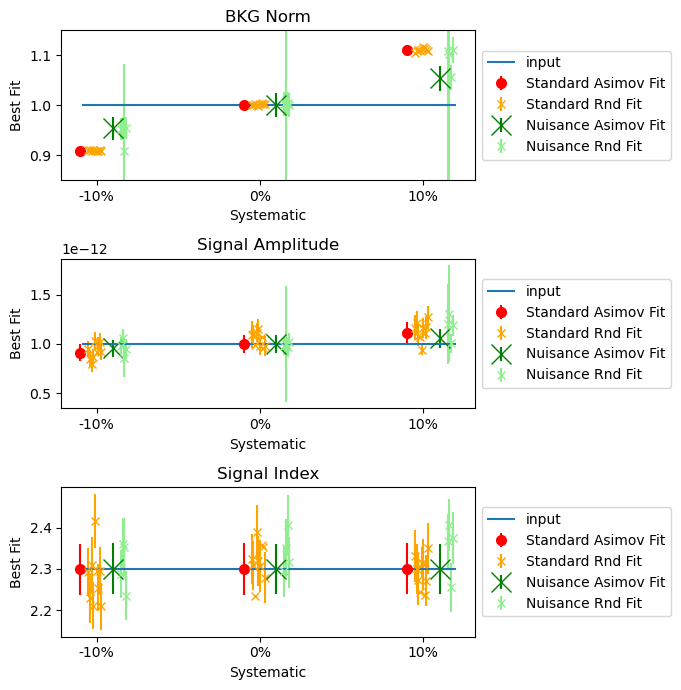

In [28]:
fig, axs = plt.subplots(3,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for j in range(3):
    label = "Standard Rnd Fit"
    for i, a in enumerate(norms_all[j][1:]):
        axs[0].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(amplitudes_all[j][1:]):
        axs[1].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(indices_all[j][1:]):
        axs[2].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)

for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
        
for j in range(3):
    label = "Nuisance Rnd Fit"
    for i, a in enumerate(norms_all_N[j][1:]):
        axs[0].errorbar(x= 1.15+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'lightgreen',
                       label = label)
    for i, a in enumerate(amplitudes_all_N[j][1:]):
        axs[1].errorbar(x= 1.15+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'lightgreen',
                       label = label)
    for i, a in enumerate(indices_all_N[j][1:]):
        axs[2].errorbar(x= 1.15+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'lightgreen',
                       label = label)
        
        
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   
